<a href="https://colab.research.google.com/github/whitefreeze/Pump-It-up-Pump-Failure-Prediction/blob/main/Pump_It_Up_Pump_Failure_Modeling_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Pump Failure Prediction](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/)
[README](https://colab.research.google.com/drive/10U7qmwrViuOV-4MjdKCuBRYVMvsH99hN?usp=sharing)

Predict the status of waterpoints/pumps and catagorize into the following three categories for 'status_group':
> * 'functional'
> * 'non functional'
> * 'functional needs repair'

Submission will include the 'id' and 'status_group' features.

## Prepare Dataset

### Import Packages

In [ ]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatplotLib
import matplotlib.pyplot as plt
## Seaborn
import seaborn as sns

# re Python library
import re

# Matplotlib Colors
import matplotlib.colors as mcolors

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

## Modeling
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Classification Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay \
#RocCurveDisplay

# Tuning
from sklearn.model_selection import GridSearchCV

# Display all columns
pd.set_option('display.max_column', None)

# Import warnings and add a filter to ignore them
import warnings
warnings.simplefilter('ignore')

### Functions

**Add evaluate_regression function if needed**

In [ ]:
## Define a function that takes in arguments and prints out a classification report and confusion matrix
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            cmap='Greens', normalize=None, classes=None,
                            figsize=(20,5), name='Classification Model',
                            average='binary', zero_division=0):
  """Takes as required arguments: a model, traing features, training labels,
  testing feature, testing labels
  Prints classification reports and confusion matrices for each data set
  returns a dataframe of metrics

  Optional arguments:
    cmap: colormap
    normalize: confusion matrix normalization ['true', 'pred', 'all' or None]
    classes: ordered list of class labels
    figsize: size of figure
    name: give your model a name
    average: how to aggregate scores for multiclass problems
    zero_division: what should the result of divide by zero be?"""

  # Gather model predictions
  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)

  # Display classification report and confusion matrices
  print('======Train Set Metrics======')
  print(metrics.classification_report(y_train, train_preds,
                                      zero_division=0,
                                      target_names=classes))

  print('======Test Set Metrics======')
  print(metrics.classification_report(y_test, test_preds,
                                      zero_division=0,
                                      target_names=classes))

  fig, axes = plt.subplots(ncols=2, figsize=figsize)

  ConfusionMatrixDisplay.from_predictions(y_train, train_preds, cmap=cmap,
                                display_labels=classes,
                                normalize=normalize, ax=axes[0])
  axes[0].set_title('Train Confusion Matrix')

  ConfusionMatrixDisplay.from_predictions(y_test, test_preds, cmap=cmap,
                              display_labels=classes,
                              normalize=normalize, ax=axes[1])
  axes[1].set_title('Test Confusion Matrix')
  plt.show()

  # If there are more than 2 classes and an average has not been set,
  # set average to 'macro'

    # This if statement is throwing an error in the model evaluation: disable
    # if average == 'binary' and y_train.nunique() > 2:
  average = 'macro'

  # Create a dataframe of scores to return
  scores = pd.DataFrame()

  # Training

  scores.loc[name, 'Train Accuracy'] = accuracy_score(y_train, train_preds)
  scores.loc[name, 'Train Recall'] = recall_score(y_train, train_preds,
                                                           average=average,
                                                       zero_division=zero_division)
  scores.loc[name, 'Train Precision'] = precision_score(y_train, train_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Train F1-Score'] = f1_score(y_train, train_preds,
                                                           average=average,
                                                     zero_division=zero_division)

  # Testing
  scores.loc[name, 'Test Accuracy'] = accuracy_score(y_test, test_preds)
  scores.loc[name, 'Test Recall'] = recall_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test Precision'] = precision_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test F1-Score'] = f1_score(y_test, test_preds,
                                                           average=average,
                                                     zero_division=zero_division)

  return scores

### Source References

### Load Data

In [ ]:
# Conect to Drive
#from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
## Load Test Data
path = '/Users/whitefreeze/Downloads/Pump it Up/Test_set_values.csv'
#path = '/content/drive/MyDrive/Data Science/Coding Dojo/Course 3: ML - Advanced/Pump it Up - Data Files/Test_set_values.csv'

# skipinitialspace used to ignore spaces immediately following the delimiter
df_test = pd.read_csv(path, skipinitialspace=True)
df_test.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other


In [ ]:
## Load Training Target Data
path = '/Users/whitefreeze/Downloads/Pump it Up/training_Set_labels.csv'
#path = '/content/drive/MyDrive/Data Science/Coding Dojo/Course 3: ML - Advanced/Pump it Up - Data Files/training_Set_labels.csv'

# skipinitialspace used to ignore spaces immediately following the delimiter
df_target = pd.read_csv(path, skipinitialspace=True)
df_target.head(1)

,id,status_group
0,69572,functional


In [ ]:
## Load Training Values Data
path = '/Users/whitefreeze/Downloads/Pump it Up/training_Set_values.csv'
#path = '/content/drive/MyDrive/Data Science/Coding Dojo/Course 3: ML - Advanced/Pump it Up - Data Files/training_Set_values.csv'

# skipinitialspace used to ignore spaces immediately following the delimiter
df = pd.read_csv(path, skipinitialspace=True)
df.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [ ]:
# Display shape of dataset
df.shape

(59400, 40)

The dataset has 40 features.

In [ ]:
# Count number of features
shape = df.shape
print('Number of columns: ', shape[1])

Number of columns:  40


The dataset has 59,400 observations in the dataset.

In [ ]:
print(f'The "Pump It Up" Dataset has {len(df.index)} observations')

The "Pump It Up" Dataset has 59400 observations


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

### Data Dictionary

amount_tsh - Total static head (amount water available to waterpoint)

date_recorded - The date the row was entered

funder - Who funded the well

gps_height - Altitude of the well

installer - Organization that installed the well

longitude - GPS coordinate

latitude - GPS coordinate

wpt_name - Name of the waterpoint if there is one

num_private -

basin - Geographic water basin

subvillage - Geographic location

region - Geographic location

region_code - Geographic location (coded)

district_code - Geographic location (coded)

lga - Geographic location

ward - Geographic location

population - Population around the well

public_meeting - True/False

recorded_by - Group entering this row of data

scheme_management - Who operates the waterpoint

scheme_name - Who operates the waterpoint

permit - If the waterpoint is permitted

construction_year - Year the waterpoint was constructed

extraction_type - The kind of extraction the waterpoint uses

extraction_type_group - The kind of extraction the waterpoint uses

extraction_type_class - The kind of extraction the waterpoint uses

management - How the waterpoint is managed

management_group - How the waterpoint is managed

payment - What the water costs

payment_type - What the water costs

water_quality - The quality of the water

quality_group - The quality of the water

quantity - The quantity of water

quantity_group - The quantity of water

source - The source of the water

source_type - The source of the water

source_class - The source of the water

waterpoint_type - The kind of waterpoint

waterpoint_type_group - The kind of waterpoint


### Duplicate Observations: Identify & Address

In [ ]:
# Count number of duplicate rows in dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


### Delete Unnecessary Columns

There are a few features that may be duplicates, but will need to perform some analysis to determine if some features are exact replicas of others, or if there are unique values between them. Some of the features that need to be analyzed to determine if they are duplicates of each other are:

1.
> * *payment*
> * **payment_type** (visually analyzed: equivalent values: drop "**payment_type**")

2.
> * *scheme_name*
> * **scheme_name** (has 28,166 missing values: drop "**scheme_name**")

3.
> * *extraction_type*
> * **extraction_type_group** (visually analyzed: same values: drop "**extraction_type_group**")

4.
> * *quantity*
> * **quantity_group** (visually analyzed: same values: drop "**quantity_group**")

5.
> * *id*
> * **id** (only needed for final competition entry. will drop during initial processing. will reprocess and add 'id' back before submitting to competition.)


In [ ]:
#1. Drop 'payment_type' column
df = df.drop(columns=['payment_type'])
df.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


In [ ]:
#2. Drop 'scheme_name' column
df = df.drop(columns=['scheme_name'])
df.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


In [ ]:
#3. Drop 'extraction_type_group' column
df = df.drop(columns=['extraction_type_group'])
df.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,False,1999,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,True,2010,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,True,2009,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


In [ ]:
#4. Drop 'quantity_group' column
df = df.drop(columns=['quantity_group'])
df.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,False,1999,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,True,2010,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,True,2009,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


In [ ]:
#5. Drop 'id' column
df = df.drop(columns=['id'])
df.head(3)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,False,1999,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,True,2010,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,True,2009,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


### Data Type: Ensure Matching Data Dictionary

Display information about features.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

Four of the features remining in the datset need to have their datatypes updated:

* 'date_recorded' to date type
* 'public_meeting' to boolean
* 'permit' to boolean
* 'construction_year' to integer

In [ ]:
# Change 'date_recorded' to type integer
# df['date_recorded'] = df['date_recorded'].astype('int')

# Not able to train dataset if 'date_recorded' is type datetime...
df['date_recorded'] = pd.to_datetime(df['date_recorded'])

# Able to train dataset with data type datetime64[D]:
# df['date_recorded'].astype('datetime64[ns]')

# df['date_recorded'] = pd.Timestamp(df['date_recorded'])

df['date_recorded'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 59400 entries, 0 to 59399
Series name: date_recorded
Non-Null Count  Dtype         
--------------  -----         
59400 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 464.2 KB


In [ ]:
# Change 'public_meeting' to boolean
df['public_meeting'] = df['public_meeting'].astype('bool')

df['public_meeting'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 59400 entries, 0 to 59399
Series name: public_meeting
Non-Null Count  Dtype
--------------  -----
59400 non-null  bool 
dtypes: bool(1)
memory usage: 58.1 KB


In [ ]:
# Change 'permit' to boolean
df['permit'] = df['permit'].astype('bool')

df['permit'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 59400 entries, 0 to 59399
Series name: permit
Non-Null Count  Dtype
--------------  -----
59400 non-null  bool 
dtypes: bool(1)
memory usage: 58.1 KB


In [ ]:
# Change 'construction_year' to integer
df['construction_year'] = df['construction_year'].astype('int')

df['construction_year'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 59400 entries, 0 to 59399
Series name: construction_year
Non-Null Count  Dtype
--------------  -----
59400 non-null  int64
dtypes: int64(1)
memory usage: 464.2 KB


### Inconsistent Values: Check & Address (Categorical Columns)

* Check all values for each feature to ensure that there are no inconsistent values.

In [ ]:
# funder
print(f'Number of unique values in feature: {df.funder.nunique()}')

Number of unique values in feature: 1897


In [ ]:
# funder
df.funder.value_counts()[0:15]

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Dhv                        829
Private Individual         826
Dwsp                       811
0                          777
Norad                      765
Name: funder, dtype: int64

For 'funder' values, we can see that there are 1,897 unique values, which will be very difficult to cross check that there are no inconsistent values.

There are 777 instances for the value "0". This appears to be what was used to indicate "None" or a missing value.

In [ ]:
# installer
print(f'Number of unique values in feature: {df.installer.nunique()}')

Number of unique values in feature: 2145


For 'installer' (and similar to 'funder') values, we can see that there are 2,145 unique values. This will also be very difficult to cross check for inconsistent values.

There are also 777 instances for the value "0" in 'installer'. This, again, appears to be what was used to indicate "None" or a missing value.

In [ ]:
# installer
df.installer.value_counts()[0:50]

DWE                           17402
Government                     1825
RWE                            1206
Commu                          1060
DANIDA                         1050
KKKT                            898
Hesawa                          840
0                               777
TCRS                            707
Central government              622
CES                             610
Community                       553
DANID                           552
District Council                551
HESAWA                          539
LGA                             408
World vision                    408
WEDECO                          397
TASAF                           396
District council                392
Gover                           383
AMREF                           329
TWESA                           316
WU                              301
Dmdd                            287
ACRA                            278
World Vision                    270
SEMA                        

We can see that there are a variety of inconsistent values that include the following (a visual inspection of the dataset was also performed and added further insight into trends and typical types of inconsistent data):

> * capitalization differences
> * erroneous spacing
> * various implimentations for the same name/abbreviation
> * various positioning of "/" in joint ventures
> * inconsistent use of periods in names/abbreviations

An example for different spelling/abbreviation usage in names can be seen in the above value_counts:

> * 1825: Government
> *  622: Central government
> *  383: Gover
> *  222: Gove
> *  162: Centr

Also:

> * 551: District Council
> * 392: District council
> * 181: Distri

There are many, many more examples in the two features 'funder' and 'installer', some more or less obvious than others.



Plan for addressing inconsistent values in both 'funder' and 'installer' features:

* standardize usage of "/" in names
* remove all periods from names
* remove erroneous whitespace
* set all values to uppercase

This should take care of the majority of naming inconsistencies that are relatively straight forward to fix.

To alleviate variations in naming and abbreviations, more insight into the data needs to be achieved (access to a subject-matter expert would be ideal) in order to optimize any naming standardization methods developed.

#### Inconsistent Values: Clean (Uppercase)
* set all values to uppercase

##### 'funder'

In [ ]:
# View head of 'funder' to see capitalization example
df['funder'].head(10)

0                  Roman
1                Grumeti
2           Lottery Club
3                 Unicef
4            Action In A
5    Mkinga Distric Coun
6                   Dwsp
7                  Rwssp
8               Wateraid
9            Isingiro Ho
Name: funder, dtype: object

In [ ]:
# Uppercase all values in column 'funder'
df['funder'] = df['funder'].str.upper()

In [ ]:
# View head of 'funder' to verify if capitalization has been standardized
df['funder'].head(5)

0           ROMAN
1         GRUMETI
2    LOTTERY CLUB
3          UNICEF
4     ACTION IN A
Name: funder, dtype: object

##### 'installer'

In [ ]:
# View head of 'installer' to see capitalization example
df['installer'].head(10)

0           Roman
1         GRUMETI
2    World vision
3          UNICEF
4         Artisan
5             DWE
6            DWSP
7             DWE
8       Water Aid
9         Artisan
Name: installer, dtype: object

In [ ]:
# Uppercase all values in column 'installer'
df['installer'] = df['installer'].str.upper()

In [ ]:
# View head of 'installer' to verify if capitalization has been standardized
df['installer'].head(5)

0           ROMAN
1         GRUMETI
2    WORLD VISION
3          UNICEF
4         ARTISAN
Name: installer, dtype: object

#### Inconsistent Values: Clean ("/")
* standardize usage of "/" in names

In [ ]:
# Show examples of usage for "/" in values
df[df['installer'].str.contains("/", na = False)]['installer']

63               ADRA /COMMUNITY
110               ADRA/COMMUNITY
222              ADRA /COMMUNITY
274                      RWE/DWE
401               RWE/ COMMUNITY
                  ...           
59058              RCCHURCH/CEFA
59101                TASSAF/TCRS
59174        DWE/ANGLICAN CHURCH
59241            ADRA/ COMMUNITY
59331    RC CHURCH/CENTRAL GOVER
Name: installer, Length: 664, dtype: object

##### Testing Regex

Create a sample test dataframe to correctly work out regex expression.

In [ ]:
# create test DataFrame called "test"
# initialize list of elements
data = ["ADRA /COMMUNITY"], ["ADRA/COMMUNITY"], ["ADRA /COMMUNITY"], ["RWE/DWE"], ["RWE/ COMMUNITY"], ["RCCHURCH/CEFA"], ["TASSAF/TCRS"], ["DWE/ANGLICAN CHURCH"], ["ADRA/ COMMUNITY"], ["RC CHURCH/CENTRAL GOVER"]

# Create pandas DataFreame with column name
test = pd.DataFrame(data, columns = ['installer'])

# print dataframe
test

,installer
0,ADRA /COMMUNITY
1,ADRA/COMMUNITY
2,ADRA /COMMUNITY
3,RWE/DWE
4,RWE/ COMMUNITY
5,RCCHURCH/CEFA
6,TASSAF/TCRS
7,DWE/ANGLICAN CHURCH
8,ADRA/ COMMUNITY
9,RC CHURCH/CENTRAL GOVER


In [ ]:
# Regex pattern to search for
pattern = r'(\w+\s?)(/)(\s?\w+)'
text = ""
# Variable 'm' to hold each returned occurrence of the pattern
m = re.search(pattern, text)

# Use a lambda function on test['installer'] to join the captured groups with spaces.
test['installer'].str.replace(pattern,
                              lambda m: m.group(1)+' '+
                              m.group(2)+' '+
                              m.group(3))

0            ADRA  / COMMUNITY
1             ADRA / COMMUNITY
2            ADRA  / COMMUNITY
3                    RWE / DWE
4             RWE /  COMMUNITY
5              RCCHURCH / CEFA
6                TASSAF / TCRS
7        DWE / ANGLICAN CHURCH
8            ADRA /  COMMUNITY
9    RC CHURCH / CENTRAL GOVER
Name: installer, dtype: object

In [ ]:
# Use a lambda function on df['installer'] to join the captured groups with spaces.
df['installer'].str.replace(pattern,
                              lambda m: m.group(1)+' '+
                              m.group(2)+' '+
                              m.group(3)).filter(items = [110], axis=0)

110    ADRA / COMMUNITY
Name: installer, dtype: object

Using .filter at end of .str.replace showed that row 110 (that contained a "/") was indeed updated with extra spaces on each side of the forward slash.

##### 'installer'

We will now save our DataFrame in-place for the 'installer' feature.

In [ ]:
# Use a lambda function on df['installer'] to join the captured groups with spaces and save in-place.
df['installer'] = df['installer'].str.replace(pattern,
                              lambda m: m.group(1)+' '+
                              m.group(2)+' '+
                              m.group(3))

In [ ]:
# Verify usage for "/" in values
df[df['installer'].str.contains(r"/", na = False)]['installer']

63               ADRA  / COMMUNITY
110               ADRA / COMMUNITY
222              ADRA  / COMMUNITY
274                      RWE / DWE
401               RWE /  COMMUNITY
                   ...            
59058              RCCHURCH / CEFA
59101                TASSAF / TCRS
59174        DWE / ANGLICAN CHURCH
59241            ADRA /  COMMUNITY
59331    RC CHURCH / CENTRAL GOVER
Name: installer, Length: 664, dtype: object

##### 'funder'

We will repeat the same cleaning on the 'funder' feature.

In [ ]:
# Show usage for "/" in 'funder' values
df[df['funder'].str.contains(r"/", na = False)]['funder']

51                          DWE/NORAD
82       SWISLAND/ MOUNT MERU FLOWERS
90                         ISF/TACARE
265      SWISLAND/ MOUNT MERU FLOWERS
274                 NORAD /GOVERNMENT
                     ...             
59058                   RCCHURCH/CEFA
59101                  TASSAF/ DANIDA
59141               WORLD VISION/ADRA
59174             DWE/ANGLICAN CHURCH
59331                 RC CHURCH/CENTR
Name: funder, Length: 756, dtype: object

In [ ]:
# Use a lambda function on df['funder'] to join the captured groups with spaces and save in-place.
df['funder'] = df['funder'].str.replace(pattern,
                              lambda m: m.group(1)+' '+
                              m.group(2)+' '+
                              m.group(3))

In [ ]:
# Verify usage for "/" in 'funder' values
df[df['funder'].str.contains(r"/", na = False)]['funder']

51                          DWE / NORAD
82       SWISLAND /  MOUNT MERU FLOWERS
90                         ISF / TACARE
265      SWISLAND /  MOUNT MERU FLOWERS
274                 NORAD  / GOVERNMENT
                      ...              
59058                   RCCHURCH / CEFA
59101                  TASSAF /  DANIDA
59141               WORLD VISION / ADRA
59174             DWE / ANGLICAN CHURCH
59331                 RC CHURCH / CENTR
Name: funder, Length: 756, dtype: object

We have cleaned both 'funder' and 'installer' in regards to forward slash usage.

And while there are now spaces on each side of the forward slash (as we wanted, in order to make further cleaning easier), there are now double/multiple spaces in our values.

This is fine as we will address the spacing issue for both the additional spaces that we just injected, as well as the ones pre-existing in our dataset, in a future step.

#### Inconsistent Values: Clean (Periods)
* remove all periods from names

##### Testing Regex

We will test our "." replacement feature on a test set.

In [ ]:
# create test DataFrame called "test_dot"
# initialize list of elements
data = ['OIKOS E .AFRICA'], ['DR. MATOMOLA'], ['I.E.C'], ['T. N. KARUGENDO'], ['DR. MATOMOLA'], ['OIKOS E.AFRICA'], ['NAISHU CONSTRUCTION CO. LTD']

# Create pandas DataFreame with column name
test_dot = pd.DataFrame(data, columns = ['installer'])

# print dataframe
test_dot

,installer
0,OIKOS E .AFRICA
1,DR. MATOMOLA
2,I.E.C
3,T. N. KARUGENDO
4,DR. MATOMOLA
5,OIKOS E.AFRICA
6,NAISHU CONSTRUCTION CO. LTD


In [ ]:
# Remove all periods from values in test_dot dataset
test_dot['installer'] = test_dot['installer'].str.replace(".", " ")
# Verify
test_dot

,installer
0,OIKOS E AFRICA
1,DR MATOMOLA
2,I E C
3,T N KARUGENDO
4,DR MATOMOLA
5,OIKOS E AFRICA
6,NAISHU CONSTRUCTION CO LTD


Code figured out. Will now apply to entire dataset.

##### 'installer'

We will update the 'installer' feature.

In [ ]:
# Verify usage for "." in values
df[df['installer'].str.contains(".", na = False)]['installer']

0               ROMAN
1             GRUMETI
2        WORLD VISION
3              UNICEF
4             ARTISAN
             ...     
59394        ML APPRO
59395             CES
59396            CEFA
59398            MUSA
59399           WORLD
Name: installer, Length: 55745, dtype: object

In [ ]:
# Remove all periods from values in 'installer'
df.installer = df['installer'].str.replace(".", " ")

In [ ]:
# Verify usage for "." in values
df[df['installer'].str.contains(".", na = False)]['installer']

0               ROMAN
1             GRUMETI
2        WORLD VISION
3              UNICEF
4             ARTISAN
             ...     
59394        ML APPRO
59395             CES
59396            CEFA
59398            MUSA
59399           WORLD
Name: installer, Length: 55745, dtype: object

##### 'funder'

We will update the 'funder' feature.

In [ ]:
# Verify usage for "." in values
df[df['funder'].str.contains(".", na = False)]['funder']

0                  ROMAN
1                GRUMETI
2           LOTTERY CLUB
3                 UNICEF
4            ACTION IN A
              ...       
59394         WORLD BANK
59395    GERMANY REPUBLI
59396        CEFA-NJOMBE
59398              MALEC
59399         WORLD BANK
Name: funder, Length: 55765, dtype: object

In [ ]:
# Remove all periods from values in 'funder'
df.funder = df['funder'].str.replace(".", " ")

In [ ]:
# Verify usage for "." in values
df[df['funder'].str.contains(".", na = False)]['funder']

0                  ROMAN
1                GRUMETI
2           LOTTERY CLUB
3                 UNICEF
4            ACTION IN A
              ...       
59394         WORLD BANK
59395    GERMANY REPUBLI
59396        CEFA-NJOMBE
59398              MALEC
59399         WORLD BANK
Name: funder, Length: 55765, dtype: object

#### Inconsistent Values: Clean (Whitespace)
* remove erroneous whitespace

Note: skipinitialspace was used on loading the data, so all spaces immediately following the delimiter for all values in all features have been ignored. I believe this will be useful for this dataset.

##### 'installer'

We will update the 'installer' feature.

In [ ]:
# Remove leading and trailing whitespace in 'installer'
df['installer'] = df.installer.str.strip()

In [ ]:
# Count number of multiple spaces in values for 'installer'
df.installer.str.count('/s+').sort_values(ascending=False)

0        0.0
39572    0.0
39560    0.0
39561    0.0
39562    0.0
        ... 
59357    NaN
59366    NaN
59370    NaN
59376    NaN
59397    NaN
Name: installer, Length: 59400, dtype: float64

##### 'funder'

We will update the 'funder' feature.

In [ ]:
# Remove leading and trailing whitespace in 'funder'
df['funder'] = df.funder.str.strip()

In [ ]:
# Count number of multiple spaces in values for 'funder'
df.funder.str.count('/s+').sort_values(ascending=False)

0        0.0
39566    0.0
39555    0.0
39556    0.0
39557    0.0
        ... 
59357    NaN
59366    NaN
59370    NaN
59376    NaN
59397    NaN
Name: funder, Length: 59400, dtype: float64

* Do the space counts above include total number of spaces in each observation? Or maximum spaces in a row for each observation? Are double/multiple spaces already removed from both features?

* Is the following line of code needed? Have all of the double/multiple spaces already been removed?

In [ ]:
# Remove duplicate white spaces in all columns
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True)

A [research paper](https://www.mdpi.com/2220-9964/6/10/316) has been found that can give some insight into this dataset and some of the abbreviations used in the 'funder' and 'installer' features.

### Impossible Values: Check & Address (Numerical Columns)

* Check all values for each feature to ensure that there are no inconsistent or impossible values.

* We will display the descriptive statistics for the numeric columns only for the purpose of detecting impossible values, not for finding or removing outliers (as removing outliers could lead to data leakage)

In [ ]:
# Display the descriptive statistics for the numeric columns
df.describe(include= "number")

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


### Missing Values: Identify & Address


#### Zero Values: Removal

Find how "null" values are expressed in this dataset and delete them so that they can be imputed in a future step.

After further inspecting this dataset {and as observed before in the section "*Inconsistent Values: Check & Address (Categorical Columns)*"} it seems that zero is the placeholder for "null" values.

Each feature will need to be verified as to whether zero was used to indicate a "null" value.

##### 'construction_year'

'construction_year' is the only numerical feature that it is clearly does not make sense to have a minimum value of zero. All zero values for this feature should be deleted and imputed later on.

In [ ]:
# Display all values by year for 'construction_year'
df['construction_year'].value_counts().sort_index()

0       20709
1960      102
1961       21
1962       30
1963       85
1964       40
1965       19
1966       17
1967       88
1968       77
1969       59
1970      411
1971      145
1972      708
1973      184
1974      676
1975      437
1976      414
1977      202
1978     1037
1979      192
1980      811
1981      238
1982      744
1983      488
1984      779
1985      945
1986      434
1987      302
1988      521
1989      316
1990      954
1991      324
1992      640
1993      608
1994      738
1995     1014
1996      811
1997      644
1998      966
1999      979
2000     2091
2001      540
2002     1075
2003     1286
2004     1123
2005     1011
2006     1471
2007     1587
2008     2613
2009     2533
2010     2645
2011     1256
2012     1084
2013      176
Name: construction_year, dtype: int64

In [ ]:
# Show examples of usage for zero in values
print(list(np.where(df["construction_year"] == 0)))

[array([    4,     6,     7, ..., 59393, 59397, 59398])]


In [ ]:
# Verify value of row #4 before replacement
df['construction_year'].filter(items = [4], axis=0)

4    0
Name: construction_year, dtype: int64

In [ ]:
# Use first index from above that returned target value (0): verify NaN returned
# MUST use special nullable integer data type 'Int64' to have a null value that is an integer
df['construction_year'].replace(0, np.nan).astype('Int64').filter(items = [4], axis=0)

4    <NA>
Name: construction_year, dtype: Int64

In [ ]:
# Remove all zero values from 'construction_year'
df['construction_year'] = df['construction_year'].replace(0, np.nan).astype('Int64')
df['construction_year'].filter(items = [4], axis=0)

4    <NA>
Name: construction_year, dtype: Int64

In [ ]:
# Verify 0 replaced with null integer value (no zero values remain)
df.loc[df['construction_year'] == 0]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group


In [ ]:
# Display datatype for 'construction_year'
df.construction_year.info()

<class 'pandas.core.series.Series'>
RangeIndex: 59400 entries, 0 to 59399
Series name: construction_year
Non-Null Count  Dtype
--------------  -----
38691 non-null  Int64
dtypes: Int64(1)
memory usage: 522.2 KB


In [ ]:
# Display all values by year for 'construction_year'
print(df.construction_year.info())

<class 'pandas.core.series.Series'>
RangeIndex: 59400 entries, 0 to 59399
Series name: construction_year
Non-Null Count  Dtype
--------------  -----
38691 non-null  Int64
dtypes: Int64(1)
memory usage: 522.2 KB
None


In 'construction_year', all "zero" values (0) have been replaced with < NA > and feature is of type integer.

##### 'longitude'

In [ ]:
# Show examples of usage for zero in values
print(list(np.where(df["longitude"] == 0)))

[array([   21,    53,   168, ..., 59295, 59324, 59374])]


In [ ]:
# Verify value of row #21 before replacment
df['longitude'].filter(items = [21], axis=0)

21    0.0
Name: longitude, dtype: float64

In [ ]:
# Use first index from above that returned target value (0): verify NaN returned
df['longitude'].replace(0, np.nan).filter(items = [21], axis=0)

21   NaN
Name: longitude, dtype: float64

In [ ]:
# Remove all zero values from 'longitude'
df['longitude'] = df['longitude'].replace(0, np.nan)
df['longitude'].filter(items = [21], axis=0)

21   NaN
Name: longitude, dtype: float64

In [ ]:
# Verify 0 replaced with NaN
print(list(np.where(df["longitude"] == 0)))

[array([], dtype=int64)]


In 'longitude', all "zero" values (0) have been replaced with NaN.

##### 'latitude'

Visually inspecting dataset reveals zero is missing, but has -2.00E-08 instead of zero.

In [ ]:
# Show examples of usage for zero in values
# Visually inspecting dataset reveals zero is missing, but has -2.00E-08 instead of zero
print(list(np.where(df["latitude"] == -2.00E-08)))

[array([   21,    53,   168, ..., 59295, 59324, 59374])]


In [ ]:
# Verify value of row #21 before replacment
df['latitude'].filter(items = [21], axis=0)

21   -2.000000e-08
Name: latitude, dtype: float64

In [ ]:
# Use first index from above that returned target value (-2.00E-08): verify NaN returned
df['latitude'].replace(-2.00E-08, np.nan).filter(items = [21], axis=0)

21   NaN
Name: latitude, dtype: float64

In [ ]:
# Remove all zero values from 'latitude'
df['latitude'] = df['latitude'].replace(-2.00E-08, np.nan)
df['latitude'].filter(items = [21], axis=0)

21   NaN
Name: latitude, dtype: float64

In [ ]:
# Verify -2.00E-08 replaced with NaN
print(list(np.where(df["latitude"] == -2.00E-08)))

[array([], dtype=int64)]


In 'latitude', all "zero" values (-2.00E-08) have been replaced with NaN.

##### 'district_code'

This column has only a few zero values, but all of those rows also have an 'lga' value of "Mpwapwa". All other 'district_code' values in the 'lga' column having "Mpwapwa" as the value, have a 'district_code' of one (1). I will replace the zeroes with ones based on this.

In [ ]:
# Save column name to variable
col_name = 'district_code'

# Show examples of usage for zero in values and save to variable
zero_value = list(np.where(df[col_name] == 0))
zero_value_index = zero_value[0][0]
print(f'The first zero value in column "{col_name}" is in row {zero_value_index}.\n')

# Verify value of row zero_value before replacement
print(f"Row {zero_value_index}'s value before changing is: {df[col_name][zero_value_index]}\n")

# List row numbers that contain the zero values
print(f"There are zero values are in the column in the following rows: \n{zero_value[0]}\n")

# Use first index from above that returned target value (0): verify NaN returned
print(f'The previous rows with zero values will be tested to see if they can be temporarily changed to the value 1: \n{df[col_name].replace(0, 1).filter(zero_value[0], axis=0)}')

The first zero value in column "district_code" is in row 895.

Row 895's value before changing is: 0

There are zero values are in the column in the following rows: 
[  895  2499  4706  5214 16752 16889 19591 21288 22277 23353 24022 28494
 37469 37635 38706 38761 40524 44207 45943 55466 56641 56730 58757]

The previous rows with zero values will be tested to see if they can be temporarily changed to the value 1: 
895      1
2499     1
4706     1
5214     1
16752    1
16889    1
19591    1
21288    1
22277    1
23353    1
24022    1
28494    1
37469    1
37635    1
38706    1
38761    1
40524    1
44207    1
45943    1
55466    1
56641    1
56730    1
58757    1
Name: district_code, dtype: int64


In [ ]:
# Save the removal of all zero values from col_name
df[col_name] = df[col_name].replace(0, 1)
print(f"Row {zero_value_index}'s value after changing is: {df[col_name][zero_value_index]}\n")

# Verify 0 replaced with 1
print(f'The number of rows with a value of zero is now: {list(np.where(df[col_name] == 0))[0]}')

Row 895's value after changing is: 1

The number of rows with a value of zero is now: []


##### 'population'

This column has 21,381 zero values. However, there is no straight-forward way to impute those values to a better value than zero. The zero values in 'population' will be left as they are.

In [ ]:
# Save column name to variable
col_name = 'population'

# Show examples of usage for zero in values and save to variable
zero_value = list(np.where(df[col_name] == 0))
zero_value_index = zero_value[0][0]
print(f'The first zero value in column "{col_name}" is in row {zero_value_index}.\n')

# Verify value of row zero_value before replacement
print(f"Row {zero_value_index}'s value before changing is: {df[col_name][zero_value_index]}\n")

# List row numbers that contain the zero values
print(f"There are zero values are in the column in the following {len(zero_value[0])} rows: \n{zero_value[0]}\n")


The first zero value in column "population" is in row 4.

Row 4's value before changing is: 0

There are zero values are in the column in the following 21381 rows: 
[    4     6     7 ... 59393 59397 59398]



##### 'public_meeting'

This column has 5,055 zero values. However, these values represent a boolean value, and as such, will not be altered.

##### 'permit'

This column has 17,492 zero values. However, these values represent a boolean value, and as such, will not be altered.

##### 'population'

This column has 21,381 zero values. However, there is no straight-forward way to impute those values to a better value than zero. The zero values in 'population' will be left as they are.

##### All Others

All other features were checked for zero values and none were found.

### Imputation Strategy (for Missing Values) & Justification

In [ ]:
# Identify any missing values per feature
df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                 1812
latitude                  1812
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting               0
recorded_by                  0
scheme_management         3877
permit                       0
construction_year        20709
extraction_type              0
extraction_type_class        0
management                   0
management_group             0
payment                      0
water_quality                0
quality_group                0
quantity                     0
source                       0
source_type                  0
source_c

### Inconsistent Values: Check & Address (Categorical Columns)

#### 'funder'

Strategy: most_frequent

#### 'installer'

Strategy: most_frequent

#### 'subvillage'

Strategy: most_frequent (preferably most_frequent within the same district/region)

#### 'public_meeting'

Strategy: most_frequent

#### 'scheme_management'

Strategy: most_frequent

#### 'permit'

Strategy: most_frequent

#### 'construction_year'

Strategy: most_frequent, as year should be an integer value.

### Impossible Values: Check & Address (Numerical Columns)

#### 'latitude'

Strategy: mean

#### 'longitude'

Strategy: mean

In [ ]:
# Verify all columns have been updated to the correct datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   amount_tsh             59400 non-null  float64       
 1   date_recorded          59400 non-null  datetime64[ns]
 2   funder                 55765 non-null  object        
 3   gps_height             59400 non-null  int64         
 4   installer              55745 non-null  object        
 5   longitude              57588 non-null  float64       
 6   latitude               57588 non-null  float64       
 7   wpt_name               59400 non-null  object        
 8   num_private            59400 non-null  int64         
 9   basin                  59400 non-null  object        
 10  subvillage             59029 non-null  object        
 11  region                 59400 non-null  object        
 12  region_code            59400 non-null  int64         
 13  d

### Data Type: Ensure Matching Data Dictionary, Again

Display information about features.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   amount_tsh             59400 non-null  float64       
 1   date_recorded          59400 non-null  datetime64[ns]
 2   funder                 55765 non-null  object        
 3   gps_height             59400 non-null  int64         
 4   installer              55745 non-null  object        
 5   longitude              57588 non-null  float64       
 6   latitude               57588 non-null  float64       
 7   wpt_name               59400 non-null  object        
 8   num_private            59400 non-null  int64         
 9   basin                  59400 non-null  object        
 10  subvillage             59029 non-null  object        
 11  region                 59400 non-null  object        
 12  region_code            59400 non-null  int64         
 13  d

## Explore Data



### Exploratory Visualization #1

#### Visualization

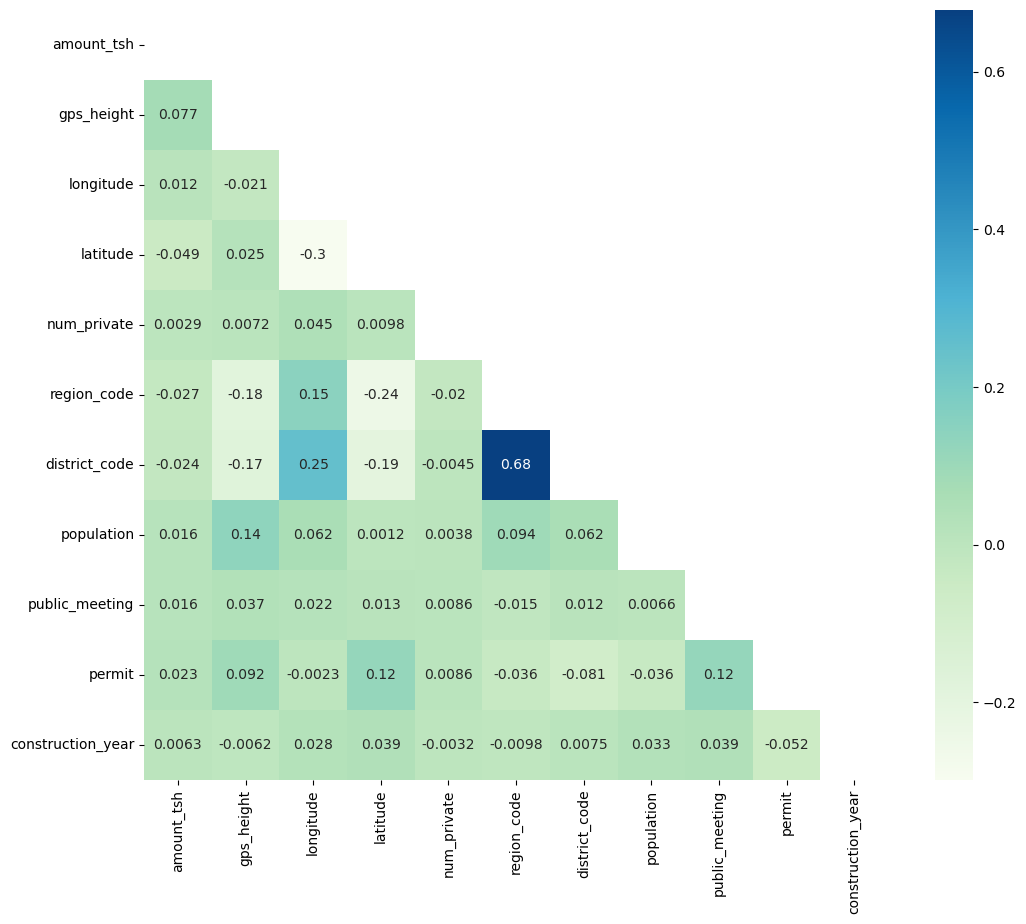

In [ ]:
# Visualization & settings
corr = df.corr()
mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(figsize = (12,10))
ax = sns.heatmap(corr, cmap= 'GnBu', annot = True, mask = mask);

#### Explanation

There is some correlation between the following numberical features:

Very Strong, Positive (0.68): 'district_code' and 'region_code'
* This is not surprizing, as the larger part of the country will only have the same smaller parts of the country contained within itself.

Very Strong, Positive (0.66): 'construction_year' and 'gps_height'
* While there may be a correlation between these two, I am puzzled as to what significance or useful/reliable insight this would bring.

Moderately Strong, Negative (-0.43): 'latitude' and 'longitude'
* As all of the locations are within the same, moderately-sized country, having a correlation between latitude and longitude is not surprising.

Moderately Strong, Positive (0.40): 'construction_year' and 'longitude'
* Again, I am puzzled as to how this correlation might be useful or reliable.

There are no more correlations with a value greater than ±0.30 from zero.

### Exploratory Visualization #2

#### Visualization

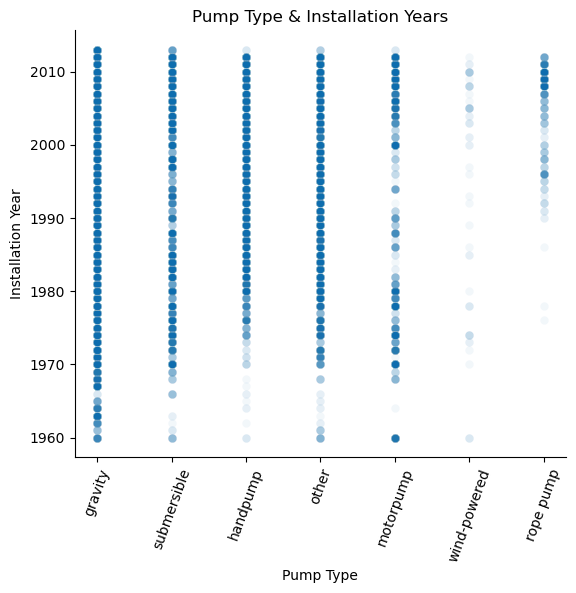

In [ ]:
# Set palette color via set_palette
sns.set_palette("GnBu_r")

# Visualization & settings
ax = sns.relplot(data=df,
                 x='extraction_type_class', y='construction_year',
                 alpha= 0.05,
                 height=5, aspect=6/5
                 )
ax.set_axis_labels('Pump Type','Installation Year')
ax.set(title='Pump Type & Installation Years')
ax.tick_params(axis='x', rotation=70);

#### Explanation

We can see that there have been many water pumps, of various types, installed in the country over the years. Some of the pumps appear to be very old, as the information goes all the way back to 1960. As people will most likely continue to need water, both the age and types of the pumps will probably big factors in determining how often servicing will be required to keep them operational.

### Exploratory Visualization #3

#### Visualization

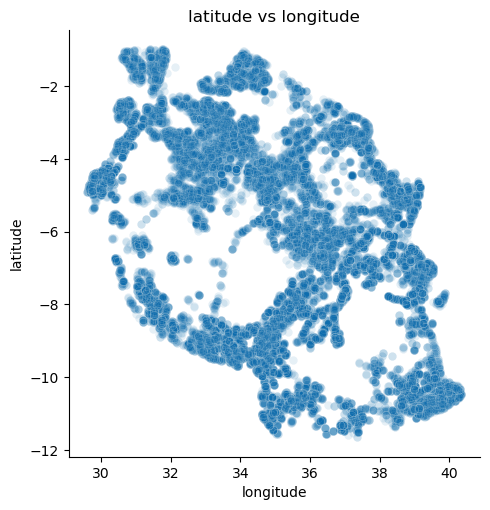

In [ ]:
ax = sns.relplot(data=df,
                 x='longitude', y='latitude',
                 alpha= 0.10,
                 height=5, aspect=5/5
                 )
ax.set_axis_labels('longitude','latitude')
ax.set(title='latitude vs longitude')
ax.tick_params(axis='x', rotation=0);

#### Explanation

By plotting the latitude and longitude for each water pump in the country, we can see what resembles an outline of Tanzania (or a head...)! From this visualization we can see that there are pumps all over the country, and probably not just in the cities. This makes checking on each pump regularly, to see if it requires maintenance or not, a very difficult task. This would probably be a difficult undertaking for even the most advanced countries. People need access to good, clean water for their families, animals, gardens and farms. Achieving the goal of being able to predict maintenance needs proactively will help reduce the amount of time people will be without access to this life-giving resource.

### Exploratory Visualization #4

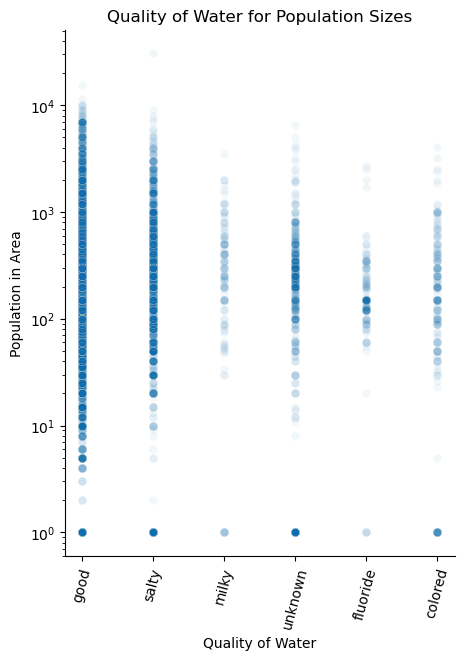

In [ ]:
# Set palette color via set_palette
sns.set_palette("GnBu_r")

# Visualization & settings
ax = sns.relplot(data=df,
                 x='quality_group', y='population',
                 alpha= 0.05,
                 height=6, aspect=5/6
                 )
ax.set(yscale="log")
ax.set_axis_labels('Quality of Water','Population in Area')
ax.set(title='Quality of Water for Population Sizes')
ax.tick_params(axis='x', rotation=75);

### Exploratory Visualization A

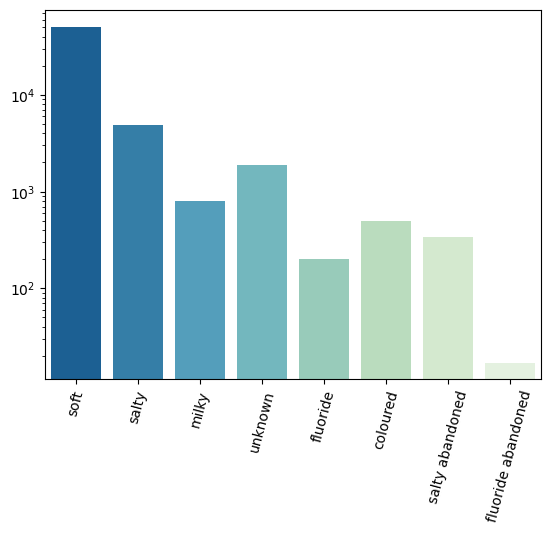

In [ ]:
# Visualization & settings
fig, ax = plt.subplots()
g = sns.countplot(data=df, x='water_quality', palette='GnBu_r')
# Set Y scale to display in logarithmic scale to account for large difference in values
g.set_yscale("log")
ax.set(xlabel='', ylabel = '')
ax.tick_params(axis='x', rotation=75)
plt.show()

### Exploratory Visualization B

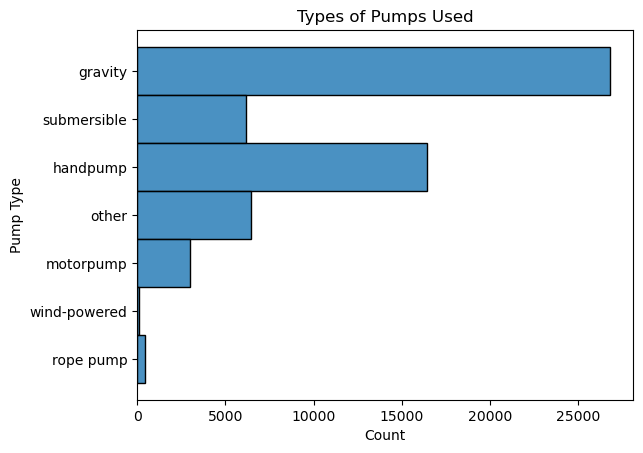

In [ ]:
# Set palette color via set_palette as .histplot does not accept palette color option without hue also being set
sns.set_palette("GnBu_r")

# Visualization & settings
fig, ax = plt.subplots()
sns.histplot(data=df, y='extraction_type_class')
ax.set_title('Types of Pumps Used')
ax.set_xlabel('Count')
ax.set_ylabel('Pump Type');

### Exploratory Visualization C

#### Visualization

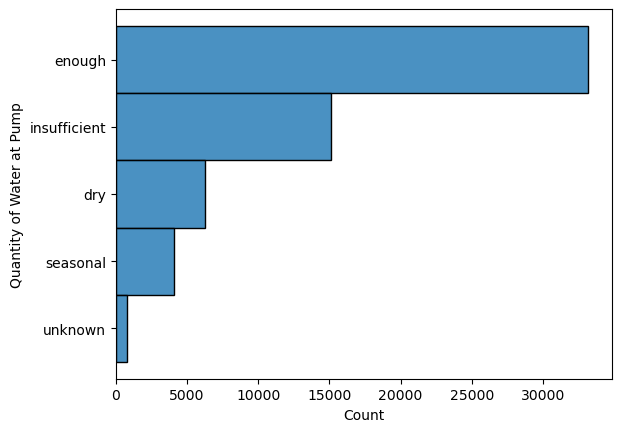

In [ ]:
# Set palette color via set_palette as .histplot does not accept palette color option without hue also being set
sns.set_palette("GnBu_r")

# Visualization & settings
fig, ax = plt.subplots()
g = sns.histplot(data=df, y='quantity')
ax.set(xlabel='Count', ylabel='Quantity of Water at Pump')
plt.show();

#### Explanation

This graph shows that most of the water points have enough water, but around half of that number are insufficient. Of the water points with insufficient supply, around two thirds of that number are either dry or seasonal. All together, almost half of the water supply levels are either not able to meet water demand levels or are simply not able to be used, at all.

Water is an incredibly necessary resource and when almost half of the wells are unable to supply the water needed, people suffer. This can be even more starkly felt in rural areas where water cannot be easily imported or distributed.

### Exploratory Visualization D

In [ ]:
# Sort values for 'payment' by count into a DataFrame
payment_sorted = pd.DataFrame(df['payment'].value_counts().sort_values(ascending=False))
payment_sorted

,payment
never pay,25348
pay per bucket,8985
pay monthly,8300
unknown,8157
pay when scheme fails,3914
pay annually,3642
other,1054


In [ ]:
# Transpose DataFrame (swap columns and rows) to assist with visualization
payment_sorted_transposed = payment_sorted.T
payment_sorted_transposed

,never pay,pay per bucket,pay monthly,unknown,pay when scheme fails,pay annually,other
payment,25348,8985,8300,8157,3914,3642,1054


#### Visualization

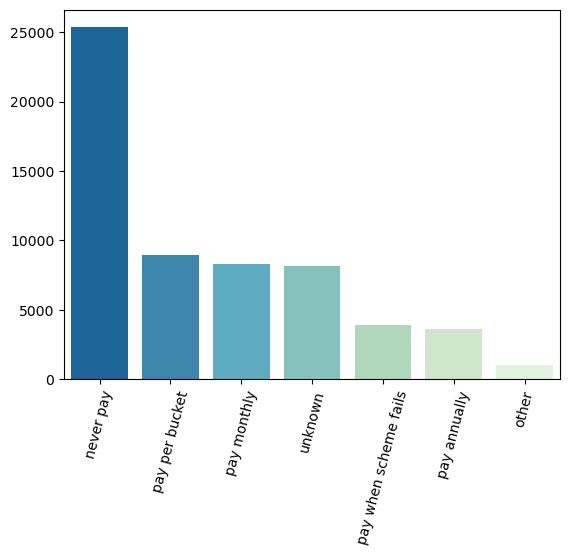

In [ ]:
# Visualization & settings
# Display values for 'payment' in order from most frequest to least frequent
fig, ax = plt.subplots()
g = sns.barplot(data=payment_sorted_transposed, palette='GnBu_r')
ax.set(xlabel='', ylabel = '')
ax.tick_params(axis='x', rotation=75)
plt.show();

### Exploratory Visualization E

#### Visualization

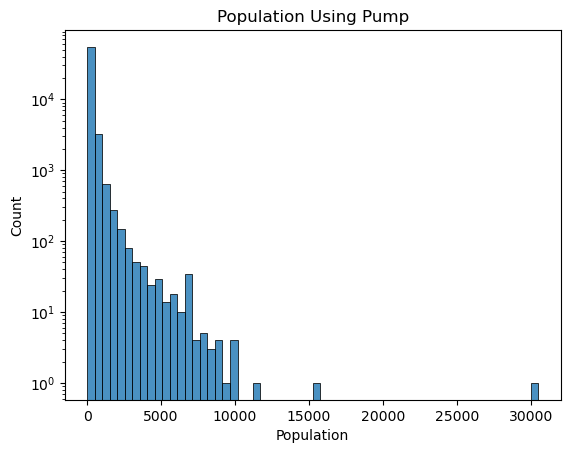

In [ ]:
# Set palette color via set_palette as .histplot does not accept palette color option without hue also being set
sns.set_palette("GnBu_r")

# Visualization & settings
fig, ax = plt.subplots()
g = sns.histplot(data=df, x='population', bins=60)
g.set_yscale("log")
ax.set_title('Population Using Pump')
ax.set_xlabel('Population')
ax.set_ylabel('Count');

#### Explanation

This graph shows the population around each water point/water pump. As this chart is scaled logarithmically for the number of pumps, it can be seen that for populations over four or five thousand, there are only a handful of pumps in those denser population areas. On the other hand, hundreds, thousands, and even tens of thousands of pumps are located in very small towns and villages, perhaps even where there are no people living, but only small herds of local livestock passing through.

## Modeling



### Modeling Preparation

Create a copy of the DataFrame to train the model

In [ ]:
# Display current columns in DataFrame
df.head(1)


,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,6000.0,2011-03-14,ROMAN,1390,ROMAN,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,False,1999,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [ ]:
# Create df copy
# Initial copy will exclude features with unresolved missing values.
# Future copies will include those features once they are resolved.
df_train = df[[
               'amount_tsh',
               # 'date_recorded',  # error due to datatype
               'gps_height',
               'wpt_name',
               'num_private',
               'basin',
               'region',
               'region_code',
               'district_code',
               'lga',
               'ward',
               'population',
               'extraction_type',
               'extraction_type_class',
               'management',
               'management_group',
               'payment',
               'water_quality',
               'quality_group',
               'quantity',
               'source',
               'source_type',
               'waterpoint_type',
               'waterpoint_type_group'
              ]]
df_train.head(1)

,amount_tsh,gps_height,wpt_name,num_private,basin,region,region_code,district_code,lga,ward,population,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,waterpoint_type,waterpoint_type_group
0,6000.0,1390,none,0,Lake Nyasa,Iringa,11,5,Ludewa,Mundindi,109,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,communal standpipe,communal standpipe


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   gps_height             59400 non-null  int64  
 2   wpt_name               59400 non-null  object 
 3   num_private            59400 non-null  int64  
 4   basin                  59400 non-null  object 
 5   region                 59400 non-null  object 
 6   region_code            59400 non-null  int64  
 7   district_code          59400 non-null  int64  
 8   lga                    59400 non-null  object 
 9   ward                   59400 non-null  object 
 10  population             59400 non-null  int64  
 11  extraction_type        59400 non-null  object 
 12  extraction_type_class  59400 non-null  object 
 13  management             59400 non-null  object 
 14  management_group       59400 non-null  object 
 15  pa

In [ ]:
# Create copy of the target df and remove 'id' column for initial processing
df_target_single = df_target[['status_group']]
df_target_single.head(1)

,status_group
0,functional


### Sample Split the Data

In [ ]:
# Assign optimized copy of DataFrame to use as X
# Randomly sample 10% of the DataFrame to make PCA processing possible
X = df_train.sample(frac = 0.1, random_state=42)

# Assign provided training target DataFrame to use as y
# Randomly sample the same 10% of the DataFrame rows as X above
y = df_target_single.sample(frac = 0.1, random_state=42)



#  1% used for troubleshooting
## X = df_train.sample(frac = 0.01, random_state=42)

#  1% used for troubleshooting
## y = df_target_single.sample(frac = 0.01, random_state=42)

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [ ]:
# Check class balance for target feature
y_train.value_counts(normalize=True)

status_group           
functional                 0.540067
non functional             0.391470
functional needs repair    0.068462
dtype: float64

### Column Transformer

In [ ]:
# Instantiate Column Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Scaler
scaler = StandardScaler()

In [ ]:
# Numeric pipeline
numeric_pipe = make_pipeline(scaler)
numeric_pipe

# Categorical pipeline
categorical_pipe = make_pipeline(ohe)
categorical_pipe

# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

# Column Transformer
preprocessor = make_column_transformer(number_tuple, category_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13c080220>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13c080d30>)])

In [ ]:
# Fit on preprocessor pipeline
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13c080220>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13c080d30>)])

In [ ]:
# Transform Testing & Training Data
train_ohe = preprocessor.transform(X_train)
test_ohe = preprocessor.transform(X_test)

### PCA Fit/Transform

In [ ]:
# Instantiate PCA at 80% explained variance
pca = PCA(.8)

In [ ]:
# Create a transformer pipeline
transformer = make_pipeline(preprocessor, pca)

### XGBoost Pipeline & Evaluation

In [ ]:
# Instantiate model
xgbc = XGBClassifier(random_state=42,
                    eval_metric='mlogloss') # to avoid warning messages

In [ ]:
# Create modeling pipeline
##xgbc_pipe = make_pipeline(transformer, xgbc)
xgbc_pipe = make_pipeline(transformer, xgbc)

In [ ]:
# Train the model on the data
xgbc_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13c080220>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignor...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [ ]:
# Display accuracy metric to evaluate model performance
print('Training accuracy:', xgbc_pipe.score(X_train, y_train))
print('Testing accuracy:', xgbc_pipe.score(X_test, y_test))

Training accuracy: 0.9815937149270483
Testing accuracy: 0.7212121212121212


======Train Set Metrics======
                         precision    recall  f1-score   support

             functional       0.98      0.99      0.98      2406
functional needs repair       0.98      0.93      0.95       305
         non functional       0.99      0.97      0.98      1744

               accuracy                           0.98      4455
              macro avg       0.98      0.97      0.97      4455
           weighted avg       0.98      0.98      0.98      4455

======Test Set Metrics======
                         precision    recall  f1-score   support

             functional       0.73      0.83      0.77       791
functional needs repair       0.36      0.17      0.24       120
         non functional       0.75      0.69      0.72       574

               accuracy                           0.72      1485
              macro avg       0.61      0.56      0.58      1485
           weighted avg       0.71      0.72      0.71      1485



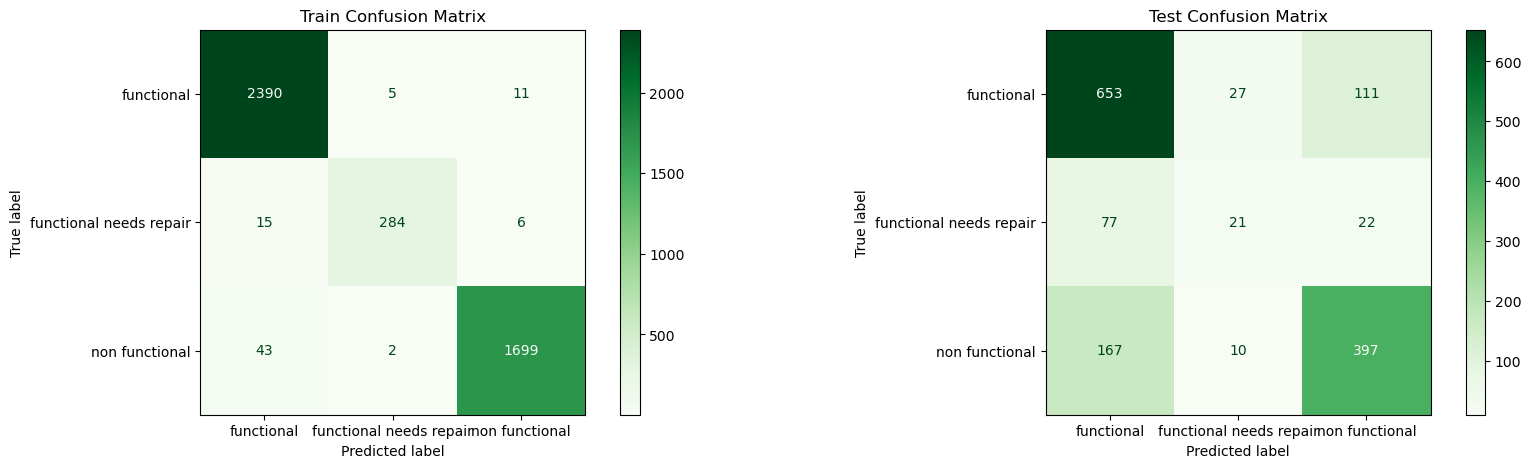

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
xgbc,0.981594,0.966232,0.980782,0.973285,0.721212,0.564058,0.613036,0.576285


In [ ]:
# Display multiple performance metrics to evaluate model performance
score = evaluate_classification(xgbc_pipe, X_train, y_train, X_test, y_test, name='xgbc')

score

### RandomForest Pipeline & Evaluation

In [ ]:
# Instantiate model
rfc = RandomForestClassifier(random_state=42)

In [ ]:
# Create a transformer pipeline
rfc_pipe = make_pipeline(transformer, rfc)

In [ ]:
# Train the model on the data
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13c080220>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13c080d30>)])),
                                 ('pca', PCA(n_components=0.8))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [ ]:
# Display accuracy metric to evaluate model performance
print('Training accuracy:', rfc_pipe.score(X_train, y_train))
print('Testing accuracy:', rfc_pipe.score(X_test, y_test))

Training accuracy: 0.9860830527497194
Testing accuracy: 0.7158249158249158


======Train Set Metrics======
                         precision    recall  f1-score   support

             functional       0.99      0.99      0.99      2406
functional needs repair       0.97      0.96      0.96       305
         non functional       0.99      0.98      0.99      1744

               accuracy                           0.99      4455
              macro avg       0.98      0.98      0.98      4455
           weighted avg       0.99      0.99      0.99      4455

======Test Set Metrics======
                         precision    recall  f1-score   support

             functional       0.72      0.83      0.77       791
functional needs repair       0.34      0.15      0.21       120
         non functional       0.74      0.68      0.71       574

               accuracy                           0.72      1485
              macro avg       0.60      0.55      0.56      1485
           weighted avg       0.70      0.72      0.70      1485



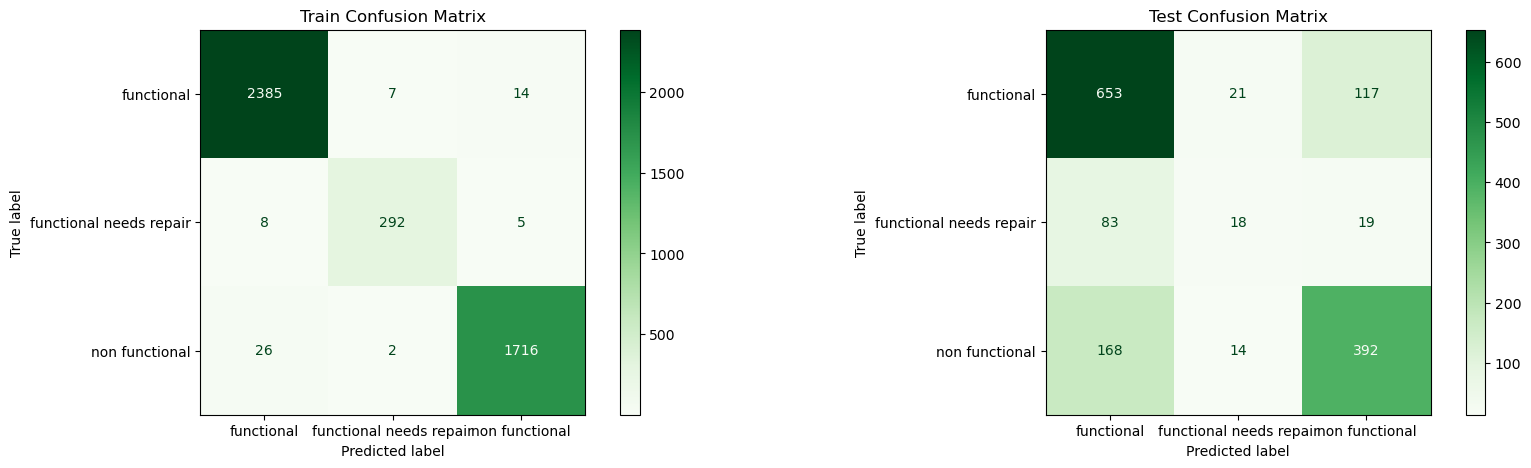

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
xgbc,0.981594,0.966232,0.980782,0.973285,0.721212,0.564058,0.613036,0.576285
rfc,0.986083,0.977531,0.981698,0.979596,0.715825,0.552821,0.601464,0.563343


In [ ]:
# Display mulitple performance metrics to evaluate model performance
rfc_score = evaluate_classification(rfc_pipe, X_train, y_train, X_test, y_test, name='rfc')

score = pd.concat([score, rfc_score])
score

### KNN Pipeline & Evaluation

In [ ]:
# Instantiate model
knn = KNeighborsClassifier(n_neighbors=1)

In [ ]:
# Create a transformer pipeline
knn_pipe = make_pipeline(transformer, knn)

In [ ]:
# Train the model on the data
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13c080220>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13c080d30>)])),
                                 ('pca', PCA(n_components=0.8))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

In [ ]:
# Display accuracy metric to evaluate model performance
print('Training accuracy:', knn_pipe.score(X_train, y_train))
print('Testing accuracy:', knn_pipe.score(X_test, y_test))

Training accuracy: 0.9838383838383838
Testing accuracy: 0.6666666666666666


======Train Set Metrics======
                         precision    recall  f1-score   support

             functional       0.99      0.99      0.99      2406
functional needs repair       0.97      0.95      0.96       305
         non functional       0.98      0.98      0.98      1744

               accuracy                           0.98      4455
              macro avg       0.98      0.97      0.98      4455
           weighted avg       0.98      0.98      0.98      4455

======Test Set Metrics======
                         precision    recall  f1-score   support

             functional       0.70      0.74      0.72       791
functional needs repair       0.30      0.25      0.27       120
         non functional       0.68      0.65      0.66       574

               accuracy                           0.67      1485
              macro avg       0.56      0.55      0.55      1485
           weighted avg       0.66      0.67      0.66      1485



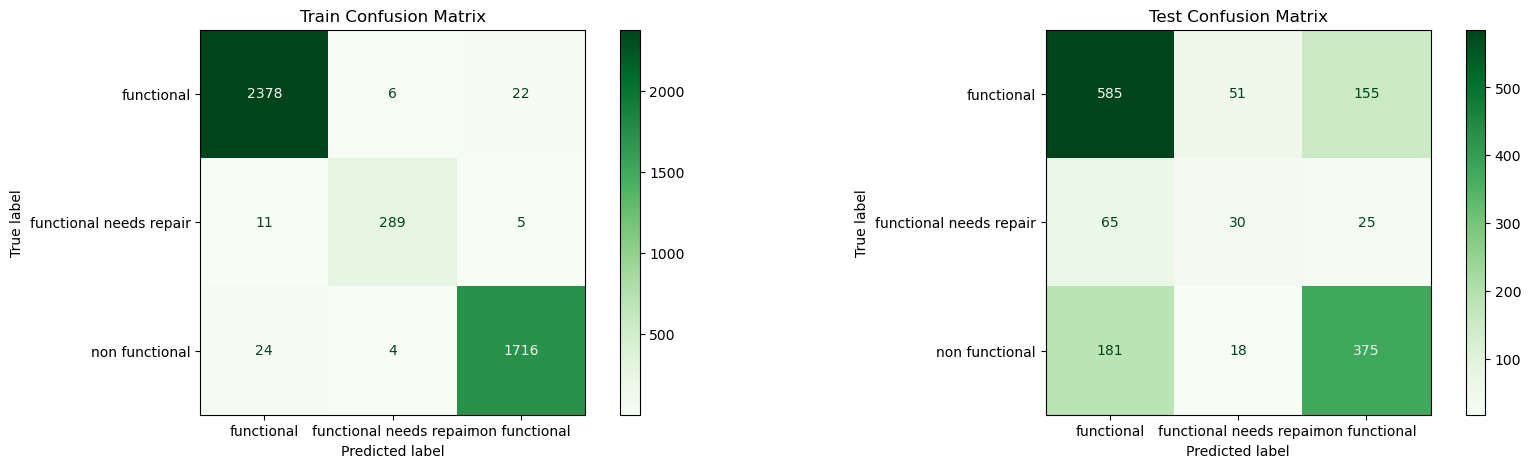

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
xgbc,0.981594,0.966232,0.980782,0.973285,0.721212,0.564058,0.613036,0.576285
rfc,0.986083,0.977531,0.981698,0.979596,0.715825,0.552821,0.601464,0.563343
knn,0.983838,0.973283,0.978853,0.976036,0.666667,0.547627,0.560892,0.553203


In [ ]:
# Display mulitple performance metrics to evaluate model performance
knn_score = evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test, name='knn')

score = pd.concat([score, knn_score])
score

## Model Parameter Tuning

### XGBoost Tuning

In [ ]:
# Get parameter list
xgbc_pipe.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('columntransformer',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('pipeline-1',
                                                     Pipeline(steps=[('standardscaler',
                                                                      StandardScaler())]),
                                                     <sklearn.compose._column_transformer.make_column_selector object at 0x13c080220>),
                                                    ('pipeline-2',
                                                     Pipeline(steps=[('onehotencoder',
                                                                      OneHotEncoder(handle_unknown='ignore',
                                                                                    sparse=False))]),
                                                     <sklearn.compose._column_transformer.make_column_selector 

In [ ]:
param_grid = {'xgbclassifier__max_depth': range(3,10),
              'xgbclassifier__n_estimators': [100]}

In [ ]:
xgbc_pipe_gs = GridSearchCV(xgbc_pipe, param_grid)

In [ ]:
xgbc_pipe_gs.fit(X_train, y_train)
print('Best XGBoost Parameters:')
print(xgbc_pipe_gs.best_params_)
xgbc_best_pipe = xgbc_pipe_gs.best_estimator_
print(f'Accuracy of best XGBoost model is: {xgbc_best_pipe.score(X_test, y_test)}')

Best RandomForest Parameters:
{'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 100}
Accuracy of best RandomForest model is: 0.7333333333333333


### XGBoost Tuned

Best XGBoost Parameters:

* 'xgbclassifier__max_depth': 4,
* 'xgbclassifier__n_estimators': 100


======Train Set Metrics======
                         precision    recall  f1-score   support

             functional       0.84      0.95      0.89      2406
functional needs repair       0.92      0.42      0.58       305
         non functional       0.91      0.82      0.87      1744

               accuracy                           0.87      4455
              macro avg       0.89      0.73      0.78      4455
           weighted avg       0.87      0.87      0.86      4455

======Test Set Metrics======
                         precision    recall  f1-score   support

             functional       0.71      0.86      0.78       791
functional needs repair       0.44      0.13      0.21       120
         non functional       0.76      0.66      0.71       574

               accuracy                           0.72      1485
              macro avg       0.64      0.55      0.56      1485
           weighted avg       0.71      0.72      0.71      1485



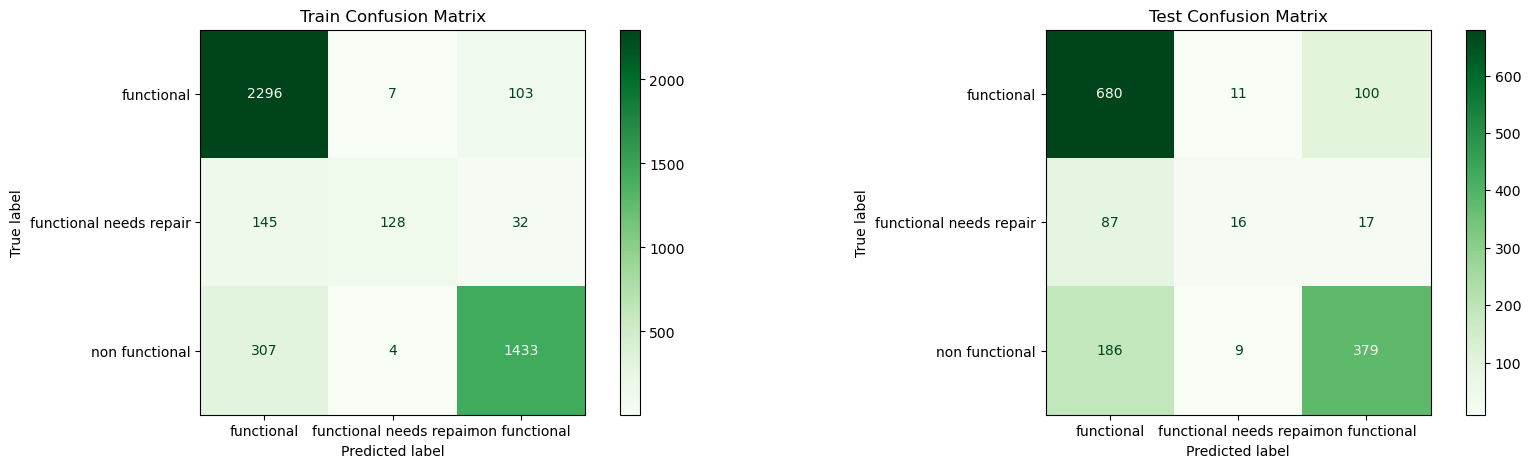

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
xgbc,0.865769,0.731876,0.890094,0.777624,0.723906,0.551094,0.640698,0.564452


In [ ]:
# Instantiate model
xgbc_tuned = XGBClassifier(max_depth=4,
                           n_estimators=100,
                           eval_metric='mlogloss', # to avoid warning messages
                           random_state=42)

# Create modeling pipeline
xgbc_pipe_tuned = make_pipeline(transformer, xgbc_tuned)

# Train the model on the data
xgbc_pipe_tuned.fit(X_train, y_train)

# Display multiple performance metrics to evaluate model performance
score_tuned = evaluate_classification(xgbc_pipe_tuned, X_train, y_train, X_test, y_test, name='xgbc')

score_tuned

### RandomForest Tuning

In [ ]:
# Get parameter list
rfc_pipe.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('columntransformer',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('pipeline-1',
                                                     Pipeline(steps=[('standardscaler',
                                                                      StandardScaler())]),
                                                     <sklearn.compose._column_transformer.make_column_selector object at 0x13c080220>),
                                                    ('pipeline-2',
                                                     Pipeline(steps=[('onehotencoder',
                                                                      OneHotEncoder(handle_unknown='ignore',
                                                                                    sparse=False))]),
                                                     <sklearn.compose._column_transformer.make_column_selector 

In [ ]:
est_depths = [estimator.get_depth() for estimator in rfc.estimators_]
max(est_depths)

37

In [ ]:
n_ests = [50, 100, 150, 200, 250]
param_grid = {'randomforestclassifier__max_depth': [max(est_depths)],
              'randomforestclassifier__n_estimators': n_ests}

In [ ]:
rfc_pipe_gs = GridSearchCV(rfc_pipe, param_grid)

In [ ]:
rfc_pipe_gs.fit(X_train, y_train)
print('Best RandomForest Parameters:')
print(rfc_pipe_gs.best_params_)
rfc_best_pipe = rfc_pipe_gs.best_estimator_
print(f'Accuracy of best RandomForest model is: {rfc_best_pipe.score(X_test, y_test)}')

Best RandomForest Parameters:
{'randomforestclassifier__max_depth': 37, 'randomforestclassifier__n_estimators': 150}
Accuracy of best RandomForest model is: 0.7131313131313132


### RandomForest Tuned

Best RandomForest Parameters:

* 'randomforestclassifier__max_depth': 37,
* 'randomforestclassifier__n_estimators': 150


Training accuracy: 0.8127946127946128
Testing accuracy: 0.7299663299663299
======Train Set Metrics======
                         precision    recall  f1-score   support

             functional       0.76      0.98      0.85      2406
functional needs repair       1.00      0.04      0.08       305
         non functional       0.93      0.72      0.81      1744

               accuracy                           0.81      4455
              macro avg       0.90      0.58      0.58      4455
           weighted avg       0.84      0.81      0.79      4455

======Test Set Metrics======
                         precision    recall  f1-score   support

             functional       0.69      0.94      0.79       791
functional needs repair       1.00      0.02      0.03       120
         non functional       0.85      0.60      0.70       574

               accuracy                           0.73      1485
              macro avg       0.84      0.52      0.51      1485
           weigh

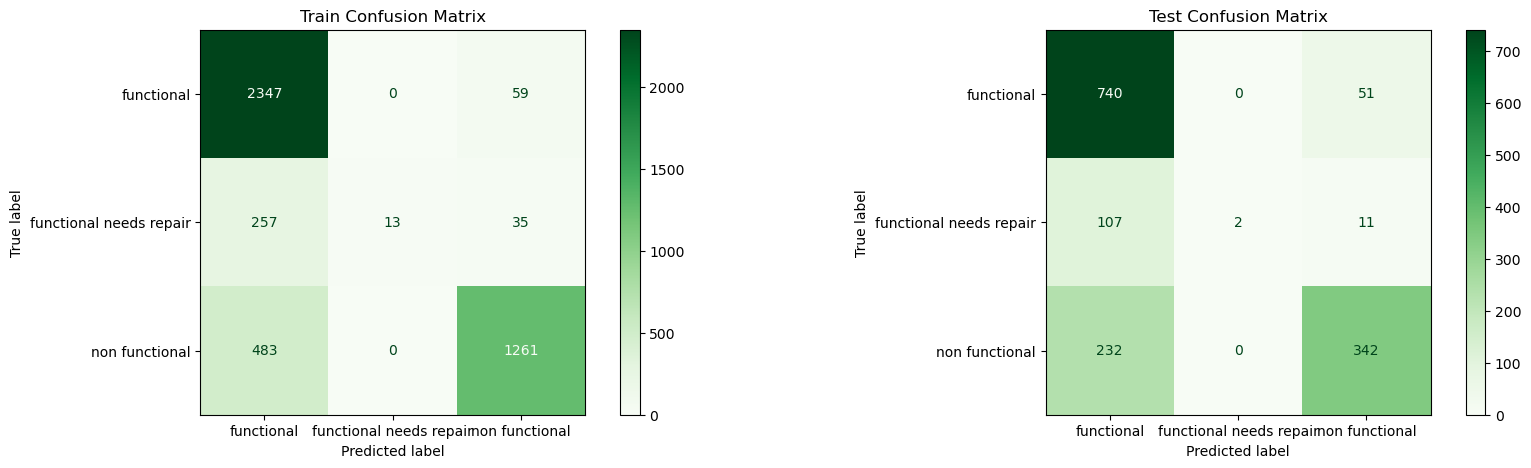

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
xgbc,0.865769,0.731876,0.890094,0.777624,0.723906,0.551094,0.640698,0.564452
rfc,0.812795,0.580384,0.896971,0.583371,0.729966,0.516003,0.844118,0.507872


In [ ]:
# Instantiate model
rfc_tuned = RandomForestClassifier(max_depth=37, n_estimators=150,random_state=42)

# Create a transformer pipeline
rfc_pipe_tuned = make_pipeline(transformer, rfc_tuned)

# Train the model on the data
rfc_pipe_tuned.fit(X_train, y_train)

# Display accuracy metric to evaluate model performance
print('Training accuracy:', rfc_pipe_tuned.score(X_train, y_train))
print('Testing accuracy:', rfc_pipe_tuned.score(X_test, y_test))

# Display mulitple performance metrics to evaluate model performance
rfc_score_tuned = evaluate_classification(rfc_pipe_tuned, X_train, y_train, X_test, y_test, name='rfc')

score_tuned = pd.concat([score_tuned, rfc_score_tuned])
score_tuned

### KNN Tuning

In [ ]:
# Get parameter list
knn_pipe.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('columntransformer',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('pipeline-1',
                                                     Pipeline(steps=[('standardscaler',
                                                                      StandardScaler())]),
                                                     <sklearn.compose._column_transformer.make_column_selector object at 0x13c080220>),
                                                    ('pipeline-2',
                                                     Pipeline(steps=[('onehotencoder',
                                                                      OneHotEncoder(handle_unknown='ignore',
                                                                                    sparse=False))]),
                                                     <sklearn.compose._column_transformer.make_column_selector 

In [ ]:
param_grid = {'kneighborsclassifier__n_neighbors': [5],
              'kneighborsclassifier__p': [2],
              'kneighborsclassifier__weights': ['distance', 'uniform']
             }

> * n_neighbors returned 5 as optimal in a previous run. [1,3,5,9]

> * n_neighbors returned 10 as optimal in a previous run. [2,4,6,8,10]

> * n_neighbors returned 5 as optimal in a previous run. [5,10]
&
> * p value of 2 returned as optimal in same run 2. [1,2]




In [ ]:
knn_pipe_gs = GridSearchCV(knn_pipe, param_grid)

In [ ]:
knn_pipe_gs.fit(X_train, y_train)
print('Best KNN Parameters:')
print(knn_pipe_gs.best_params_)
knn_best_pipe = knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {knn_best_pipe.score(X_test, y_test)}')

Best KNN Parameters:
{'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'uniform'}
Accuracy of best KNN model is: 0.6835016835016835


### KNN Tuned

Best KNN Parameters:

* 'kneighborsclassifier__n_neighbors': 5,
* 'kneighborsclassifier__p': 2,
* 'kneighborsclassifier__weights': 'uniform'}

======Train Set Metrics======
                         precision    recall  f1-score   support

             functional       0.78      0.90      0.84      2406
functional needs repair       0.63      0.29      0.40       305
         non functional       0.84      0.75      0.79      1744

               accuracy                           0.80      4455
              macro avg       0.75      0.64      0.67      4455
           weighted avg       0.79      0.80      0.79      4455

======Test Set Metrics======
                         precision    recall  f1-score   support

             functional       0.69      0.81      0.75       791
functional needs repair       0.27      0.11      0.15       120
         non functional       0.71      0.63      0.67       574

               accuracy                           0.68      1485
              macro avg       0.55      0.52      0.52      1485
           weighted avg       0.66      0.68      0.67      1485



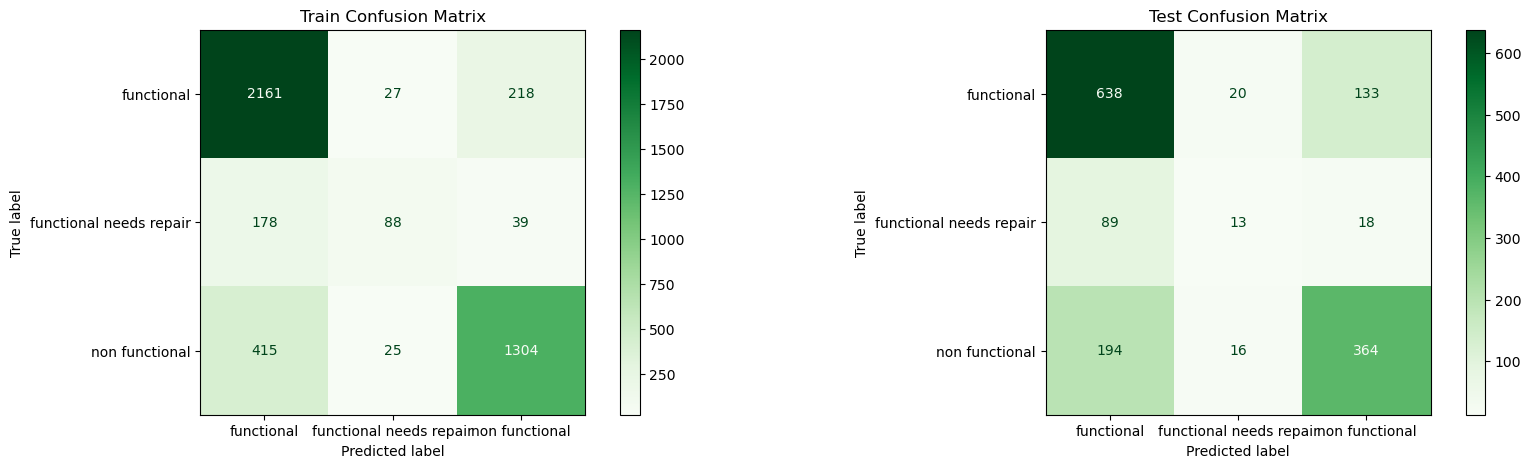

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
xgbc,0.865769,0.731876,0.890094,0.777624,0.723906,0.551094,0.640698,0.564452
rfc,0.812795,0.580384,0.896971,0.583371,0.729966,0.516003,0.844118,0.507872
knn,0.983838,0.973283,0.978853,0.976036,0.666667,0.547627,0.560892,0.553203


In [ ]:
# Instantiate model
knn_tuned = KNeighborsClassifier(n_neighbors=5, p=2, weights='uniform')

# Create a transformer pipeline
knn_pipe_tuned = make_pipeline(transformer, knn_tuned)

# Train the model on the data
knn_pipe_tuned.fit(X_train, y_train)

# Display mulitple performance metrics to evaluate model performance
knn_score_tuned = evaluate_classification(knn_pipe_tuned, X_train, y_train, X_test, y_test, name='knn_tuned')

score_tuned = pd.concat([score_tuned, knn_score])
score_tuned

## Model Selection: Best

Based on the three tuned models, the best performing model is:
* XGBoost

As observed in the results of score_tuned, we can see that XGBoost essentially tied for highest Test Accuracy. We can all notice that it has the highest Test Recall score.

Even though the RandomForest model has a much higher Test Precision result, the goal of this modeling should be to focus on the Recall score over Precision or even Accuracy, considering the stakes and purpose of the research. Similar to disease or fraud detection, we need to reduce the number of False Negatives so that repairs/treatment can be performed where needed, not letting any go undetected.



Now that the optimal model and tuned parameters have been selected using smaller fractions of the available dataset and fewer features, the following changes can be made for the most accurate predictions:
* PCA: increase % of explained variance
* Features: increase cleaned features included
* Features: perform additional cleaning on excluded features
* Sample Fraction: increase % of dataset included

### Model Preprocessing

In [ ]:
# Assign optimized copy of DataFrame to use as X
# Randomly sample 60%+ of the DataFrame to make PCA processing possible
X = df_train.sample(frac = 0.2, random_state=42)

# Assign provided training target DataFrame to use as y
# Randomly sample the same 60%+ of the DataFrame rows as X above
y = df_target_single.sample(frac = 0.2, random_state=42)

In [ ]:
X.isna().sum()

amount_tsh               0
gps_height               0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
extraction_type          0
extraction_type_class    0
management               0
management_group         0
payment                  0
water_quality            0
quality_group            0
quantity                 0
source                   0
source_type              0
waterpoint_type          0
waterpoint_type_group    0
dtype: int64

In [ ]:
y.isna().sum()

status_group    0
dtype: int64

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Check class balance for target feature
y_train.value_counts(normalize=True)

status_group           
functional                 0.545006
non functional             0.383614
functional needs repair    0.071380
dtype: float64

In [ ]:
# Instantiate Column Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Scaler
scaler = StandardScaler()

# Numeric pipeline
numeric_pipe = make_pipeline(scaler)
numeric_pipe

# Categorical pipeline
categorical_pipe = make_pipeline(ohe)
categorical_pipe

# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

# Column Transformer
preprocessor = make_column_transformer(number_tuple, category_tuple, remainder='passthrough')
preprocessor

# Fit on preprocessor pipeline
preprocessor.fit(X_train)

# Transform Testing & Training Data
train_ohe = preprocessor.transform(X_train)
test_ohe = preprocessor.transform(X_test)

In [ ]:
# Instantiate PCA at 80% explained variance
pca = PCA(.8)

# Create a transformer pipeline
transformer = make_pipeline(preprocessor, pca)

### Model Fitting & Metrics

======Train Set Metrics======
                         precision    recall  f1-score   support

             functional       0.84      0.96      0.89      4856
functional needs repair       0.90      0.45      0.60       636
         non functional       0.92      0.82      0.87      3418

               accuracy                           0.87      8910
              macro avg       0.89      0.74      0.79      8910
           weighted avg       0.87      0.87      0.86      8910

======Test Set Metrics======
                         precision    recall  f1-score   support

             functional       0.74      0.87      0.80      1601
functional needs repair       0.59      0.19      0.29       215
         non functional       0.77      0.67      0.72      1154

               accuracy                           0.74      2970
              macro avg       0.70      0.58      0.60      2970
           weighted avg       0.74      0.74      0.73      2970



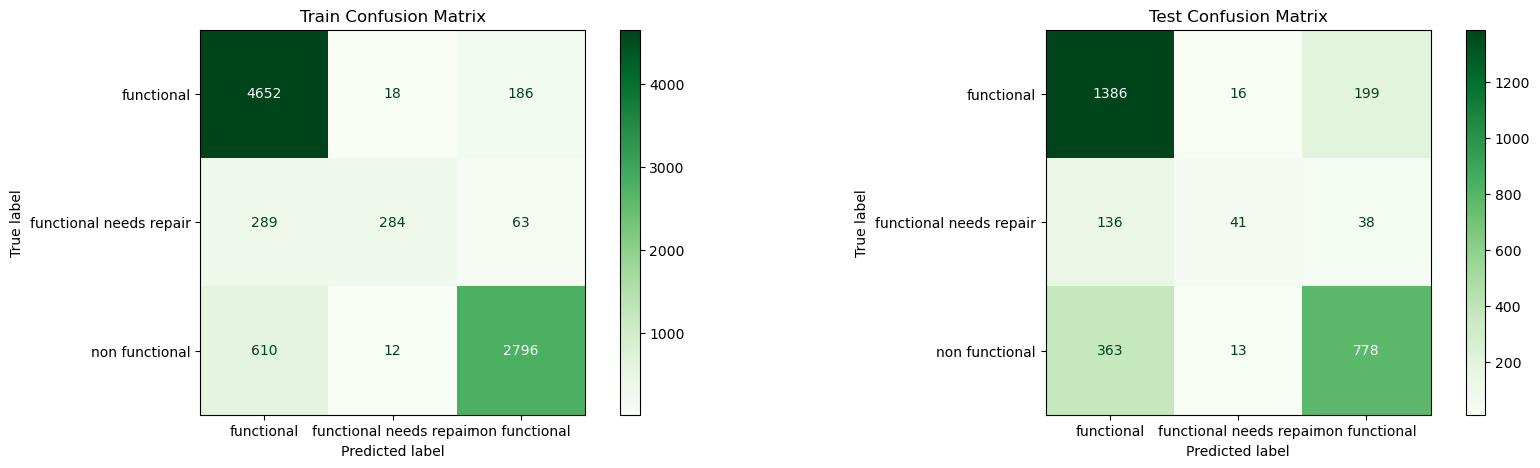

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
xgbc_full,0.867789,0.740851,0.886911,0.785714,0.742424,0.576861,0.695832,0.600094


In [ ]:
# Instantiate model
xgbc_tuned = XGBClassifier(max_depth=4,
                           n_estimators=100,
                           eval_metric='mlogloss', # to avoid warning messages
                           random_state=42)

# Create modeling pipeline
xgbc_pipe_tuned = make_pipeline(transformer, xgbc_tuned)

# Train the model on the data
xgbc_pipe_tuned.fit(X_train, y_train)

# Display multiple performance metrics to evaluate model performance
score_tuned = evaluate_classification(xgbc_pipe_tuned, X_train, y_train, X_test, y_test, name='xgbc_full')

score_tuned

### Final Results

Using XGBoost:

* Test Accuracy: 74.24%
* Test Recall:   57.68%

This model will be run again in the future with more of the datset included, but is currently limited due to extended processing times.